In [ ]:
pip install js2py

In [ ]:
# Cell 1: Installation and Imports

# Install the required OpenCV package
!pip install --quiet opencv-contrib-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [ ]:
# Cell 2: Configuration and Helper Functions

# --- CONFIGURATION ---
REFERENCE_PATH = "PHOTO.JPG"  # Make sure this file is uploaded
FACE_SIZE = (200, 200)
THRESHOLD = 80  # For LBPH, a lower score (distance) is a better match

# --- LOAD FACE DETECTOR ---
# Load the pre-trained Haar Cascade model for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# --- HELPER FUNCTION ---
def extract_face_from_bgr(img_bgr):
    """Detects the largest face, converts to grayscale, and resizes."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Detect faces with scale factor and minimum neighbors
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    if len(faces) == 0:
        return None, None # No face found

    # Find the largest face based on its area (width * height)
    x, y, w, h = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)[0]

    # Crop the grayscale image to the face region
    face = gray[y:y+h, x:x+w]
    # Resize the face to a standard size for the recognizer
    face = cv2.resize(face, FACE_SIZE)

    return face, (x, y, w, h) # Return the processed face and its coordinates

[*] Reference loaded and recognizer trained successfully. ✅


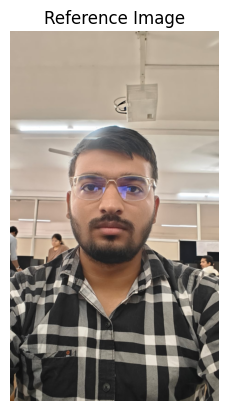

In [ ]:
# Cell 3: Load Reference Image and Train Recognizer

# Check if the reference photo exists
if not os.path.exists(REFERENCE_PATH):
    raise RuntimeError(f"Reference image '{REFERENCE_PATH}' not found. Please upload it.")

ref_img = cv2.imread(REFERENCE_PATH)
if ref_img is None:
    raise RuntimeError("Failed to read reference image. Check the file path and integrity.")

# Extract the face from your reference photo
ref_face, _ = extract_face_from_bgr(ref_img)
if ref_face is None:
    raise RuntimeError("No face detected in the reference image. Use a clear, frontal photo.")

# --- TRAIN THE RECOGNIZER ---
# Create an instance of the LBPH Face Recognizer
recognizer = cv2.face.LBPHFaceRecognizer_create()
# Train the recognizer with your reference face and a label (we use 0 for the reference person)
recognizer.train([ref_face], np.array([0], dtype=np.int32))

print("[*] Reference loaded and recognizer trained successfully. ✅")

# Display the reference image with the detected face for confirmation
plt.imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB))
plt.title("Reference Image")
plt.axis("off")
plt.show()

In [ ]:
# Cell 4: Start Webcam and Run Real-Time Recognition

# --- JAVASCRIPT FOR WEBCAM ACCESS (CORRECTED) ---
def video_stream():
  """Defines and displays the JavaScript responsible for webcam streaming."""
  js = Javascript('''
    var video;
    var stream;
    var captureCanvas;
    var captureContext;
    var PENDING_CAPTURE_PROMISE = null;

    // CORRECTED: Made the function async to handle the promise from getUserMedia
    async function startVideo() {
      // Await the result of getUserMedia before proceeding
      stream = await navigator.mediaDevices.getUserMedia({video: true});

      video = document.createElement('video');
      video.style.display = 'block';
      document.body.appendChild(video);
      captureCanvas = document.createElement('canvas');
      captureContext = captureCanvas.getContext('2d');
      video.addEventListener('loadedmetadata', () => {
        captureCanvas.width = video.videoWidth;
        captureCanvas.height = video.videoHeight;
        captureCanvas.style.display = 'none';
      });

      // Now, 'stream' is a valid MediaStream object
      video.srcObject = stream;

      // Wait for the video to start playing before resolving the promise
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
    }

    function captureFrame() {
      PENDING_CAPTURE_PROMISE = new Promise(function(resolve, reject) {
        captureContext.drawImage(video, 0, 0);
        resolve(captureCanvas.toDataURL('image/jpeg', 0.8));
      });
      return PENDING_CAPTURE_PROMISE;
    }

    function stopVideo() {
      stream.getTracks().forEach(track => track.stop());
      video.remove();
      captureCanvas.remove();
    }
  ''')
  display(js)

# --- MAIN RECOGNITION LOOP ---
print("[*] Starting webcam...")
video_stream()
eval_js('startVideo()') # Run the JavaScript to start the video
print("[*] Webcam active. Running face recognition... 📸")
print("[*] To stop, interrupt the kernel (◼️ button in Colab).")

while True:
  try:
    # 1. Capture a frame from JavaScript
    js_reply = eval_js('captureFrame()')
    if not js_reply:
      break

    # 2. Decode the frame from base64 into an OpenCV image
    img_bytes = b64decode(js_reply.split(',')[1])
    frame = cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

    # 3. Detect and recognize the face in the frame
    face_to_check, coords = extract_face_from_bgr(frame)

    if face_to_check is not None:
        # Predict the identity of the face
        label, confidence = recognizer.predict(face_to_check)
        x, y, w, h = coords

        # 4. Draw results on the frame
        if confidence < THRESHOLD:
            text = f"MATCH! (Conf: {confidence:.2f})"
            color = (0, 255, 0) # Green for a match
        else:
            text = f"Unknown (Conf: {confidence:.2f})"
            color = (0, 0, 255) # Red for unknown

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # 5. Display the processed frame in the Colab output
    cv2_imshow(frame)

  except Exception as e:
    # Stop the video stream cleanly if an error occurs or the user interrupts
    eval_js('stopVideo()')
    print(f"\nStream stopped due to an error or interruption.")
    break

Output hidden; open in https://colab.research.google.com to view.